In [1]:
import pandas as pd
from dataset.bluesky_dataset import BlueSkyDataset
from torch.utils.data import DataLoader
from utils import stratified_downsample, get_device
from utils.constants import MAX_LEN

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tqdm import tqdm


device = get_device()

test_df = pd.read_csv("./data/test.csv")
test_df = stratified_downsample(test_df, "sentiment")
test_dataset = BlueSkyDataset(posts=test_df, pre_process_text=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Roberta-Tweet Latest

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
                                                        

              precision    recall  f1-score   support

    Negative       0.55      0.56      0.55     22918
     Neutral       0.55      0.57      0.56     33388
    Positive       0.69      0.65      0.67     35256

    accuracy                           0.60     91562
   macro avg       0.59      0.59      0.59     91562
weighted avg       0.60      0.60      0.60     91562



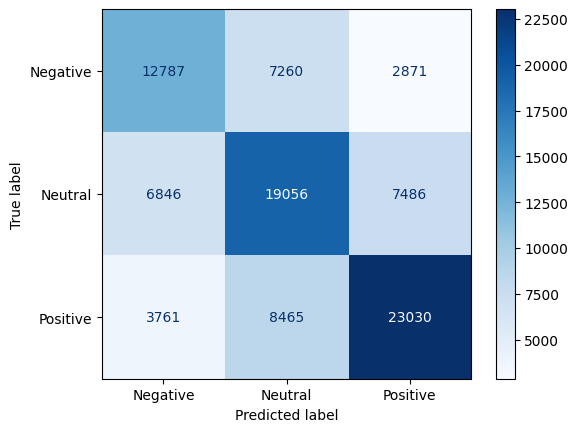

In [13]:
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


device = get_device()

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Testing loop
y_preds = []
y_true = []

progress_bar = tqdm(test_dataloader, desc="Testing", leave=False)

for x_batch, y_batch in progress_bar:
    # x_batch: list of strings
    x_batch = [preprocess(text) for text in x_batch]
    encoded_input = tokenizer(x_batch, return_tensors='pt', max_length=MAX_LEN, padding=True, truncation=True).to(
        device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        outputs = model(**encoded_input)
        predictions = outputs.logits.argmax(dim=1).cpu().numpy()

    y_preds.append(predictions.cpu())
    y_true.append(y_batch.cpu())

y_preds = torch.cat(y_preds).numpy()
y_true = torch.cat(y_true).numpy()

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
labels = [label_map[i] for i in sorted(label_map.keys())]

# Report
print(classification_report(y_true, y_preds, target_names=labels))
ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=labels, cmap='Blues')

# BERTweet

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda


Valutazione Bertweet pre-addestrato su GPU:
Accuracy: 0.5927
F1 (weighted): 0.5945
              precision    recall  f1-score   support

    Negative       0.56      0.54      0.55     22918
     Neutral       0.53      0.59      0.56     33388
    Positive       0.69      0.63      0.66     35256

    accuracy                           0.59     91562
   macro avg       0.59      0.59      0.59     91562
weighted avg       0.60      0.59      0.59     91562

Tempo totale: 68.39 s



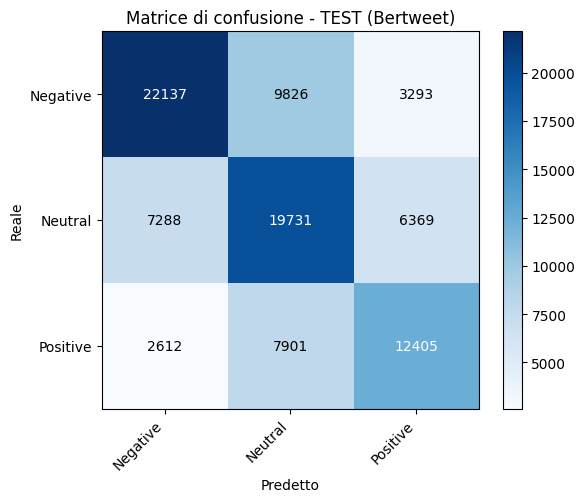

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time

from transformers import pipeline


device = get_device()

bertweet_pipe = pipeline(
  "text-classification",
  model="finiteautomata/bertweet-base-sentiment-analysis",
  tokenizer="finiteautomata/bertweet-base-sentiment-analysis",
  top_k=1,
  truncation=True,
  device=device,
)

texts = test_df['text'].tolist()
true_labels = test_df['sentiment'].tolist()

label_map = {
  'POS': 'Positive',
  'NEU': 'Neutral',
  'NEG': 'Negative'
}

def evaluate_pipeline(pipe, texts, true_labels, batch_size=32):
  start_time = time.time()
  preds = pipe(texts, batch_size=batch_size)
  duration = time.time() - start_time
  pred_labels = [label_map[p[0]['label']] if isinstance(p, list) else label_map[p['label']] for p in preds]

  acc = accuracy_score(true_labels, pred_labels)
  f1 = f1_score(true_labels, pred_labels, average='weighted')
  report = classification_report(true_labels, pred_labels)
  return {'accuracy': acc, 'f1_weighted': f1, 'report': report, 'time_sec': duration, 'pred_labels': pred_labels}

results_bertweet = evaluate_pipeline(bertweet_pipe, texts, true_labels, batch_size=1024)

print("Valutazione Bertweet pre-addestrato su GPU:")
print(f"Accuracy: {results_bertweet['accuracy']:.4f}")
print(f"F1 (weighted): {results_bertweet['f1_weighted']:.4f}")
print(results_bertweet['report'])
print(f"Tempo totale: {results_bertweet['time_sec']:.2f} s\n")

cm_bertweet = confusion_matrix(true_labels, results_bertweet['pred_labels'], labels=list(set(true_labels)))

labels_order = sorted(list(set(true_labels)))

plt.figure(figsize=(6, 5))
plt.imshow(cm_bertweet, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(labels_order)), labels_order, rotation=45, ha='right')
plt.yticks(np.arange(len(labels_order)), labels_order)

plt.title("Matrice di confusione - TEST (Bertweet)")
for i in range(len(labels_order)):
  for j in range(len(labels_order)):
    plt.text(j, i, cm_bertweet[i, j], ha='center', va='center',
            color='white' if cm_bertweet[i, j] > cm_bertweet.max()/2 else 'black')

plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.tight_layout()
plt.show()

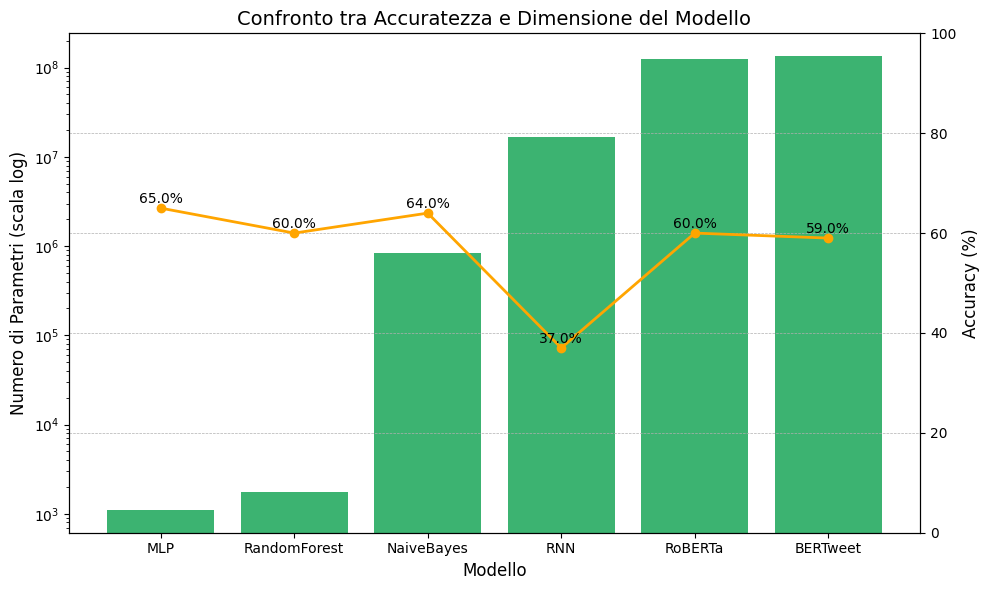

In [1]:
import matplotlib.pyplot as plt

# Dizionario con nome modello, numero di parametri e accuratezza
model_data = {
    "RoBERTa": {"param": 124_645_632, "accuracy": 0.60},
    "RNN": {"param": 16_846_979, "accuracy": 0.37},
    "BERTweet": {"param": 134_899_968, "accuracy": 0.59},
    "MLP": {"param": 1101, "accuracy": 0.65},
    "RandomForest": {"param": 1746, "accuracy": 0.60},
    "NaiveBayes": {"param": 835_776, "accuracy": 0.64}
}

# Ordina per numero di parametri (opzionale, per migliorare la leggibilità)
sorted_models = sorted(model_data.items(), key=lambda x: x[1]['param'])
models = [model[0] for model in sorted_models]
param_counts = [model[1]['param'] for model in sorted_models]
accuracies = [model[1]['accuracy'] * 100 for model in sorted_models]  # Converti in percentuale

# Crea la figura e il doppio asse
fig, ax1 = plt.subplots(figsize=(10, 6))

# Istogramma del numero di parametri (asse sinistro)
bars = ax1.bar(models, param_counts, color='mediumseagreen')
ax1.set_ylabel('Numero di Parametri (scala log)', fontsize=12)
ax1.set_xlabel('Modello', fontsize=12)
ax1.set_yscale('log')
ax1.tick_params(axis='y')
ax1.set_title('Confronto tra Accuratezza e Dimensione del Modello', fontsize=14)

# Linea dell'accuratezza (asse destro)
ax2 = ax1.twinx()
ax2.plot(models, accuracies, color='orange', marker='o', linewidth=2, label='Accuracy (%)')
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y')

# Mostra l'accuratezza sopra ogni punto
for i, acc in enumerate(accuracies):
    ax2.text(i, acc + 1, f"{acc:.1f}%", ha='center', fontsize=10)

# Aggiungi griglia e sistema layout
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
